In [2]:
import pandas as pd
from gurobipy import *
import matplotlib.pyplot as plt
import math
import numpy as np

In [4]:
booking = pd.read_excel("Data/Booking_new.xlsx")
bd_zones = pd.read_excel("Data/BreakDownZones.xlsx")
dz_to_bd = pd.read_excel("Data/DistanceMatrixDropZoneToBreakDownZone.xlsx")
drop_zones = pd.read_excel("Data/DropZones.xlsx")
bu_zones = pd.read_excel("Data/Outbound.xlsx", sheet_name='BU Zones')
bu_zones_workstations = pd.read_excel("Data/Outbound.xlsx", sheet_name='WorkStation')
bu_zones_to_flight = pd.read_excel("Data/Outbound.xlsx", sheet_name='FlightNumber-BUZone')
flight_default_processing = pd.read_excel("Data/Outbound.xlsx", sheet_name='DefaultProcessingTime')
flight_pre_processing = pd.read_excel("Data/Outbound.xlsx", sheet_name='Pre-ProcessingBufferTime')

In [5]:
dz = list(drop_zones['Name'].unique())
break_down_zones = list(bd_zones['Name'].unique())

In [6]:
dz_to_bd[['h','m','s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in dz_to_bd['TransportDuration']])

In [7]:
bd_zones[['handling_h','handling_m','handling_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in bd_zones['HandlingTimePerULD']])
bd_zones[['transport_WH_h','transport_WH_m','transport_WH_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in bd_zones['TransportationTimeToWH']])

In [8]:
booking.columns

Index(['Shipment ID', 'FlightDate', 'ShipmentArrivalDateUTC', 'ProductName',
       'ShipmentOrigin', 'ShipmentDestination', 'CarrierCode', 'Priority',
       'DropZone', 'FlightNumberArrival', 'SerialNumber', 'ArrivalULDNumber',
       'Pieces', 'Weight', 'Volume', 'BookingStatus', 'WeighCMMit',
       'VolumeUnit', 'TotalVolume', 'TotalWeight', 'TotalNumberOfPieces',
       'FlightNumberDeparture', 'ShipmentDepartureDateUTC'],
      dtype='object')

In [9]:
booking.shape

(785, 23)

In [10]:
# booking_new.groupby(['ArrivalULDNumber'])[[]].count().reset_index()
#Filter for same uld having both NRML and NML
booking['count_shipments'] = 1
multple_dropzone_check = booking.pivot_table(index=['ArrivalULDNumber'], columns='DropZone', values= 'count_shipments').reset_index()
multple_dropzone_check = multple_dropzone_check.fillna(0)
multple_dropzone_check.head()
multple_dropzone_check['Two_different_dropzones_check'] = multple_dropzone_check['DZ NML-1'] + multple_dropzone_check['DZ NRML-1'] + multple_dropzone_check['DZ NRML-2']
unique_dropzone_check = multple_dropzone_check[multple_dropzone_check.Two_different_dropzones_check==1.0]
unique_dropzone_list = list(unique_dropzone_check['ArrivalULDNumber'].unique())
booking = booking[booking['ArrivalULDNumber'].isin(unique_dropzone_list)]

In [11]:
booking['Shipment_arrival_date_time'] = pd.to_datetime(booking['ShipmentArrivalDateUTC'])
booking = booking[booking.ShipmentDepartureDateUTC != '2018-10-24T26:20:00']
booking['Shipment_departure_date_time'] = pd.to_datetime(booking['ShipmentDepartureDateUTC'])
booking['Shipment_duration'] = booking['Shipment_departure_date_time']-booking['Shipment_arrival_date_time']
booking = booking[booking.Shipment_duration>pd.Timedelta(0)]

In [12]:
dz_ship_data = booking[['DropZone','ArrivalULDNumber']]
uld_bd_data = pd.merge(dz_ship_data, dz_to_bd, left_on='DropZone', right_on='DropZoneName')
uld_bd_data['key'] = uld_bd_data['ArrivalULDNumber'].astype(str) + '_' + uld_bd_data['BreakDownZoneName']
uld_bd_data['dz_type'] =  uld_bd_data['DropZone'].apply(lambda x: x.split('-')[0]).str[3:]
uld_bd_data['bd_type1'] = uld_bd_data['BreakDownZoneName'].apply(lambda x: x.split(' ')[1])
uld_bd_data.loc[uld_bd_data['bd_type1'] == 'BD', 'bd_type1'] = "NRML-1"
uld_bd_data['bd_type'] =  uld_bd_data['bd_type1'].apply(lambda x: x.split('-')[0])
uld_bd_data['key_for_type'] = uld_bd_data.apply(lambda x: '1' if x['dz_type'] == x['bd_type'] else '0', axis=1)
# uld_bd_data = uld_bd_data[(uld_bd_data.key_for_type == '1') & (uld_bd_data.dz_type == 'NRML')]
# uld_bd_data = uld_bd_data.drop_duplicates('key')
# uld_bd_data.shape
#Some ULDS have both NML and NRML, THey for we filtering NRML only
uld_bd_data = uld_bd_data[(uld_bd_data.key_for_type == '1')]
uld_bd_data = uld_bd_data.drop_duplicates('key')
uld_bd_data.shape

(1560, 13)

In [13]:
uld_bd_data['dz_type'].unique()

array(['NRML', 'NML'], dtype=object)

In [14]:
uld_bd_data[uld_bd_data.ArrivalULDNumber==76901]

,DropZone,ArrivalULDNumber,BreakDownZoneName,DropZoneName,TransportDuration,h,m,s,key,dz_type,bd_type1,bd_type,key_for_type
6518,DZ NML-1,76901,BD NML-1,DZ NML-1,00:28:00,0,28,0,76901_BD NML-1,NML,NML-1,NML,1
6521,DZ NML-1,76901,BD NML-2,DZ NML-1,00:26:00,0,26,0,76901_BD NML-2,NML,NML-2,NML,1
6525,DZ NML-1,76901,BD NML-3,DZ NML-1,00:11:00,0,11,0,76901_BD NML-3,NML,NML-3,NML,1


In [15]:
uld_to_bd_times = tupledict(pd.Series(uld_bd_data.m.values,index=[uld_bd_data.ArrivalULDNumber, uld_bd_data.BreakDownZoneName]).to_dict())

In [16]:
booking['build_up_arrival_time'] =  booking['Shipment_arrival_date_time'] #+ np.timedelta64(2, 'h')
booking['build_up_finish_time'] =  booking['Shipment_departure_date_time'] #- np.timedelta64(1, 'h')
booking_new = booking[['ProductName', 'Priority', 'DropZone', 'ArrivalULDNumber', 'Pieces', 'Weight', 'TotalWeight',
         'FlightNumberDeparture', 'Shipment_arrival_date_time', 'Shipment_departure_date_time',
         'Shipment_duration', 'build_up_arrival_time', 'build_up_finish_time']]

In [17]:
booking_new = pd.merge(booking_new, bu_zones_to_flight, left_on='FlightNumberDeparture', right_on='FlightNumber')
booking_new = pd.merge(booking_new, bu_zones, left_on='BU Zone', right_on='Name')

In [18]:
booking_new['FlightNumberDeparture'].unique()

array([77, 78, 79, 82, 81, 75, 71, 74, 73, 72, 76, 80, 1, 2, 5, 6, 4, 3,
       25, 15, 16, 21, 22, 26, 27, 23, 17, 19, 20, 24, 18, 7, 8, 13, 9,
       10, 11, 12, 14, 46, 43, 42, 45, 48, 47, 41, 40, 49, 50, 44, 60, 65,
       66, 61, 68, 67, 69, 64, 59, 70, 63, 29, 34, 31, 36, 33, 35, 30, 38,
       39, 32, 37, 54, 57, 55, 52, 53, 51, 58, 56], dtype=object)

In [19]:
bu_workstation_count = bu_zones_workstations.groupby(['Name']).count().reset_index()
bu_workstation_count.columns = ['Name', 'Count']
bd_zone_all = pd.merge(bu_zones, bu_workstation_count, left_on='Name', right_on='Name')

In [20]:
bd_zone_all = pd.merge(bd_zone_all, bu_zones_to_flight, left_on='Name', right_on='BU Zone')
booking_new = pd.merge(booking_new, bd_zone_all, left_on='FlightNumberDeparture', right_on='FlightNumber')

In [21]:
booking_new[['ULD_handling_h','ULD_handling_m','ULD_handling_s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in booking_new['HandlingTimePerULD_x']])

In [22]:
booking_new['arrival_date'] = booking_new['Shipment_arrival_date_time'].dt.normalize()
booking_new['departure_date'] = booking_new['Shipment_departure_date_time'].dt.normalize()

In [23]:
booking_new['DropZone'].unique()

array(['DZ NRML-2', 'DZ NRML-1', 'DZ NML-1'], dtype=object)

In [24]:
#Having both NRML and NML
#booking_new = booking_new[booking_new.ArrivalULDNumber!=92852]
# booking_new['count_shipments'] = 1

In [25]:
booking_new.shape

(517, 31)

In [26]:
# # booking_new.groupby(['ArrivalULDNumber'])[[]].count().reset_index()

# multple_dropzone_check = booking_new.pivot_table(index=['ArrivalULDNumber'], columns='DropZone', values= 'count_shipments').reset_index()
# multple_dropzone_check = multple_dropzone_check.fillna(0)
# multple_dropzone_check['Two_different_dropzones_check'] = multple_dropzone_check['DZ NML-1'] + multple_dropzone_check['DZ NRML-1'] + multple_dropzone_check['DZ NRML-2']

In [27]:
# unique_dropzone_check = multple_dropzone_check[multple_dropzone_check.Two_different_dropzones_check==1.0]
# unique_dropzone_list = list(unique_dropzone_check['ArrivalULDNumber'].unique())

In [28]:
# booking_new = booking_new[booking_new['ArrivalULDNumber'].isin(unique_dropzone_list)]

In [29]:
#booking_new[booking_new.ArrivalULDNumber==76631]

In [30]:
##########################################################
##########################################################
##########################################################

In [162]:
sample_shipments = booking_new.iloc[0:50,:]
#sample_shipments = booking_new

In [163]:
#sample_shipments

In [164]:
sample_shipments['Shipment_duration_minutes'] = (sample_shipments['Shipment_duration'] / np.timedelta64(1, 'm')).astype(int)
sample_shipments['Shipment_arrival_time_minutes'] = pd.to_timedelta(sample_shipments['Shipment_arrival_date_time']).astype('timedelta64[m]').astype(int)
sample_shipments['Shipment_departure_time_minutes'] = pd.to_timedelta(sample_shipments['Shipment_departure_date_time']).astype('timedelta64[m]').astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWar

In [165]:
bd_zones.head()

,Description,Name,NumberOfWorkstations,SequenceNumber,TransportationTimeToWH,TargetProcessName,HandlingTimePerULD,handling_h,handling_m,handling_s,transport_WH_h,transport_WH_m,transport_WH_s
0,the biggest BD zone for normal ULDs,B BD NRML-1,33,1,00:30:00,NORMAL,00:24:00,0,24,0,0,30,0
1,the 2nd biggest BD zone for normal ULDs,B BD NRML-2,10,2,00:25:00,NORMAL,00:24:00,0,24,0,0,25,0
2,an animal BD zone,BD NML-1,4,3,00:40:00,ANIMAL,00:13:00,0,13,0,0,40,0
3,the biggest BD zone for ULDs that have to be c...,BD CLD-1,8,4,00:30:00,COOLED,00:17:00,0,17,0,0,30,0
4,a normal BD zone,BD NRML-1,5,5,00:30:00,NORMAL,00:20:00,0,20,0,0,30,0


In [166]:
bd_zones['Name'].unique

<bound method Series.unique of 0     B BD NRML-1
1     B BD NRML-2
2        BD NML-1
3        BD CLD-1
4       BD NRML-1
5        BD NML-2
6       BD NRML-2
7       BD NRML-3
8        BD CLD-2
9        BD NML-3
10      BD NRML-4
11       BD CLD-4
Name: Name, dtype: object>

In [167]:
new = sample_shipments[['ArrivalULDNumber', 'Shipment_duration_minutes','Shipment_arrival_time_minutes', 'Shipment_departure_time_minutes']]
df_merge= pd.merge(uld_bd_data, new, on='ArrivalULDNumber')
df_merge = df_merge.drop_duplicates('key')
bd_capacity = bd_zones[['Name','NumberOfWorkstations', 'handling_m']]
df_merge1 = df_merge.merge(bd_capacity, left_on='BreakDownZoneName', right_on='Name')

In [168]:
uld_bd_data["DropZone"].unique()

array(['DZ NRML-2', 'DZ NRML-1', 'DZ NML-1'], dtype=object)

In [169]:
df_merge1.columns

Index(['DropZone', 'ArrivalULDNumber', 'BreakDownZoneName', 'DropZoneName',
       'TransportDuration', 'h', 'm', 's', 'key', 'dz_type', 'bd_type1',
       'bd_type', 'key_for_type', 'Shipment_duration_minutes',
       'Shipment_arrival_time_minutes', 'Shipment_departure_time_minutes',
       'Name', 'NumberOfWorkstations', 'handling_m'],
      dtype='object')

In [170]:
df_merge1.head()

,DropZone,ArrivalULDNumber,BreakDownZoneName,DropZoneName,TransportDuration,h,m,s,key,dz_type,bd_type1,bd_type,key_for_type,Shipment_duration_minutes,Shipment_arrival_time_minutes,Shipment_departure_time_minutes,Name,NumberOfWorkstations,handling_m
0,DZ NRML-2,24321,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,24321_B BD NRML-1,NRML,NRML-1,NRML,1,2295,25671250,25673545,B BD NRML-1,33,24
1,DZ NRML-2,42309,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,42309_B BD NRML-1,NRML,NRML-1,NRML,1,2570,25671550,25674120,B BD NRML-1,33,24
2,DZ NRML-2,34576,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,34576_B BD NRML-1,NRML,NRML-1,NRML,1,1815,25671730,25673545,B BD NRML-1,33,24
3,DZ NRML-2,53111,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,53111_B BD NRML-1,NRML,NRML-1,NRML,1,730,25674560,25675290,B BD NRML-1,33,24
4,DZ NRML-2,53252,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,53252_B BD NRML-1,NRML,NRML-1,NRML,1,1970,25671910,25673880,B BD NRML-1,33,24


In [171]:
df_merge1[df_merge1.ArrivalULDNumber==76631]

,DropZone,ArrivalULDNumber,BreakDownZoneName,DropZoneName,TransportDuration,h,m,s,key,dz_type,bd_type1,bd_type,key_for_type,Shipment_duration_minutes,Shipment_arrival_time_minutes,Shipment_departure_time_minutes,Name,NumberOfWorkstations,handling_m


In [172]:
df_merge1['DropZone'].unique()

array(['DZ NRML-2', 'DZ NRML-1', 'DZ NML-1'], dtype=object)

In [173]:
df_merge1['Shipment_duration_minutes'].unique()

array([2295, 2570, 1815,  730, 1970, 1870, 2300, 1055,  800, 2180, 1880,
       1330, 2950, 1635, 3635, 2160, 3585,  925,  975, 2360,  570, 1360,
       2135,  675, 1750, 1925, 1210, 3035, 3060], dtype=int64)

In [174]:
df_merge1['one_hour_duration'] = 60

In [175]:
ArrivalULDNumber_list = list(df_merge1['ArrivalULDNumber'].unique())
BreakDownZoneName_list = list(df_merge1['BreakDownZoneName'].unique())

In [176]:
model = Model('BU zone model')

In [177]:
#Discretisation has been done based on each BD zone handling times
x = {}
for i in ArrivalULDNumber_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    #print(BreakDownZoneName_list1)
    for j in BreakDownZoneName_list1:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        min_time = min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique()))
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        handling_minutes = list(new_check['handling_m'].unique())[0]
        #print(shipment_arrival_time_minutes_loop, handling_minutes)
        t_start = (min_time + (int((shipment_arrival_time_minutes_loop-min_time)/handling_minutes)*handling_minutes))
        for k in range(t_start, t_start+shipment_arrival_duation_minutes_loop, handling_minutes):
            x[i,j,k] = model.addVar(vtype=GRB.BINARY)

In [179]:
x

{(24321, 'B BD NRML-1', 25671250): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'B BD NRML-1', 25671274): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'B BD NRML-1', 25671298): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'B BD NRML-2', 25671250): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'B BD NRML-2', 25671274): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'B BD NRML-2', 25671298): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'BD NRML-1', 25671250): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'BD NRML-1', 25671270): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'BD NRML-1', 25671290): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'BD NRML-2', 25671250): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'BD NRML-2', 25671270): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'BD NRML-2', 25671290): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'BD NRML-3', 25671250): <gurobi.Var *Awaiting Model Update*>,
 (24321, 'BD NRML-3', 25671270): <gurobi.Var *Awaiting Model Upda

In [182]:
# #Handling time of each bd zone take into account for the quicksum
for i in ArrivalULDNumber_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    new_check = df_merge1[(df_merge1.ArrivalULDNumber==i)]
    shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    #min_time = min(list(df_merge1[df_merge1.BreakDownZoneName.isin(BreakDownZoneName_list1)]['Shipment_arrival_time_minutes'].unique()))
    #t_start = shipment_arrival_time_minutes_loop + (handling_minutes - (shipment_arrival_time_minutes_loop%min_time))
    model.addConstr(quicksum(x[i,b,c] for b in BreakDownZoneName_list1 for c in range((min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (int((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (int((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])) == 1)
    
    
    #Each ULD has diiferent times for each breakdownzones
    
    #(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])
    
    #(min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())) + (int((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])))

In [93]:
# for i in ArrivalULDNumber_list:
#     model.addConstr(quicksum(x[i,j,k] for j, k in key, value in x.items())==1, "Every_ULD_must_be_assigned")

In [183]:
for i in ArrivalULDNumber_list:
    #for j in BreakDownZoneName_list:
        #print(int(i),str(j))
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    new_check = df_merge1[(df_merge1.ArrivalULDNumber==i)]
    shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    transport_time_each_bd_zone = list(new_check['m'].unique())[0]
        #for k in range(shipment_arrival_duation_minutes_loop):
    model.addConstr(quicksum((c-df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['m'])*x[i,b,c] for b in BreakDownZoneName_list1 for c in range((min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (int((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (int((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m'])) >= arrival_time_each_uld)

In [184]:
for j in BreakDownZoneName_list:
        #print(int(i),str(j))
    new_check = df_merge1[df_merge1.BreakDownZoneName==j]
    min_time = min(list(new_check['Shipment_arrival_time_minutes'].unique()))
    max_time = max(list(new_check['Shipment_departure_time_minutes'].unique()))
    uld_break = list(new_check['ArrivalULDNumber'].unique())
    #shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    #shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    handling_minutes = list(new_check['handling_m'].unique())[0]
    #print(handling_minutes)
    cap = list(new_check['NumberOfWorkstations'].unique())[0]
    for t in range(min_time, max_time-handling_minutes-1, handling_minutes):
        #print(t)
        uld_list1=[]
        uld_list2=[]
        for i in uld_break:
            if(t in range((min_time + (int((new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes']-min_time)/df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'])*df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'])), (min_time + (int((new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes']-min_time)/df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'])*df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))+shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'])):#new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_departure_time_minutes'])): 
                uld_list1.append(i)
                #print(t,uld_list1)
        if(len(uld_list1)!=0):
            model.addConstr(quicksum(x[a,j,t] for a in uld_list1) <= cap)

# Start time is (min_time + (int((new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes']-min_time)/df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'])*df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))
#         for i in uld_break:
#             if(t+handling_minutes in range(new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes'], (new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes']+60))):#new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_departure_time_minutes'])):
#                      uld_list2.append(i)
                     #print(t+handling_minutes,"-",uld_list2)
#         combine_list = list(np.unique(uld_list1+uld_list2))
        #print(min(t+handling_minutes,new_check[new_check.ArrivalULDNumber==21231].iloc[0]['Shipment_departure_time_minutes']))
        #print(t)
        
            #model.addConstr(quicksum(x[a,j,t] for a in uld_list1) <= cap)
        
        
#         range((new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes'] + 
#                (df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'] - 
#                 (new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes']%min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique()))))), 
#               (new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes'] + 
#                (df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'] - 
#                 (new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes']%min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))))+
#               new_check[new_check.ArrivalULDNumber==i].iloc[0]['Shipment_arrival_time_minutes'], df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m'])

In [ ]:
df_merge1[df_merge1.ArrivalULDNumber==34842]

In [ ]:
df_merge1['DropZone'].unique()

In [48]:
# t_max = model.addVar(vtype=GRB.INTEGER, obj=1.0, name="t_max")

In [49]:
# for i in ArrivalULDNumber_list:
#         #print(int(i),str(j))
#     BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
#     new_check = df_merge1[(df_merge1.ArrivalULDNumber==i)]
#     shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#     arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     transport_time_each_bd_zone = list(new_check['m'].unique())
#     model.addConstr(quicksum(c*x[i,b,c] for b in BreakDownZoneName_list1 for c in range(shipment_arrival_time_minutes_loop, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop)) <= t_max)

In [186]:
#Will try summation of arrival times as objective function
# x= x+y
obj = 0
for i in ArrivalULDNumber_list:
        #print(int(i),str(j))
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    new_check = df_merge1[(df_merge1.ArrivalULDNumber==i)]
    shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
    arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
    transport_time_each_bd_zone = list(new_check['m'].unique())
    obj += quicksum(c*x[i,b,c] for b in BreakDownZoneName_list1 for c in range((min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (int((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())) + (int((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==b]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['handling_m']))
#obj = x.sum()
#model.setObjective(obj, GRB.MAXIMIZE) 

In [187]:
model.setObjective(obj, GRB.MINIMIZE)

In [188]:
model.optimize()

Optimize a model with 507 rows, 599 columns and 1797 nonzeros
Variable types: 0 continuous, 599 integer (599 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+07]
  Objective range  [3e+07, 3e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+07]
Presolve removed 507 rows and 599 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: 7.95852e+08 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.958517260000e+08, best bound 7.958517260000e+08, gap 0.0000%


In [189]:
model.write("test.lp")

In [190]:
for i in ArrivalULDNumber_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    #print(i, "in", BreakDownZoneName_list1)
    for j in BreakDownZoneName_list1:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range((min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())) + (int((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())) + (int((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']):
            if x[i,j,k].x > 0.5:
                #print(k)
                print("DZ", i, "assigned to BD", j, "at", k)

DZ 24321 assigned to BD BD NRML-4 at 25671263
DZ 42309 assigned to BD B BD NRML-1 at 25671562
DZ 34576 assigned to BD BD NRML-4 at 25671744
DZ 53111 assigned to BD BD NRML-3 at 25674570
DZ 53252 assigned to BD B BD NRML-1 at 25671922
DZ 92841 assigned to BD BD NRML-4 at 25672030
DZ 43343 assigned to BD B BD NRML-1 at 25673002
DZ 51217 assigned to BD BD NRML-3 at 25673710
DZ 43330 assigned to BD BD NRML-3 at 25673090
DZ 49832 assigned to BD B BD NRML-1 at 25673122
DZ 80157 assigned to BD BD NRML-3 at 25672810
DZ 80158 assigned to BD BD NRML-4 at 25671666
DZ 80159 assigned to BD BD NRML-3 at 25672210
DZ 80289 assigned to BD BD NRML-3 at 25672350
DZ 53456 assigned to BD B BD NRML-1 at 25671922
DZ 55259 assigned to BD BD NRML-3 at 25671530
DZ 51212 assigned to BD BD NRML-3 at 25671730
DZ 51235 assigned to BD B BD NRML-1 at 25671586
DZ 59284 assigned to BD BD NRML-3 at 25673090
DZ 44921 assigned to BD BD NRML-3 at 25673210
DZ 49804 assigned to BD B BD NRML-1 at 25673626
DZ 49813 assigned to

<function matplotlib.pyplot.show(*args, **kw)>

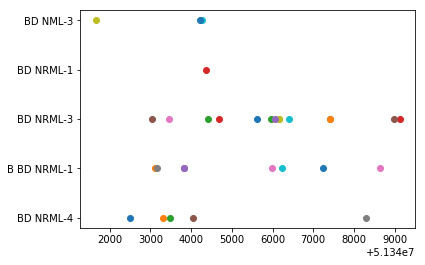

In [191]:
# visualize the optimal assignment
for i in ArrivalULDNumber_list:
    BreakDownZoneName_list1 = list(df_merge1[df_merge1.ArrivalULDNumber==i]['BreakDownZoneName'])
    for j in BreakDownZoneName_list1:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range((min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())) + (int((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))), (min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())) + (int((shipment_arrival_time_minutes_loop-min(list(df_merge1[df_merge1.BreakDownZoneName==j]['Shipment_arrival_time_minutes'].unique())))/(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))*(df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']))) +shipment_arrival_duation_minutes_loop, df_merge1[df_merge1.BreakDownZoneName==j].iloc[0]['handling_m']):
            if x[i,j,k].x > 0.5:
                #print(k)
                #print("DZ", i, "assigned to BD", j, "at", (shipment_arrival_time_minutes_loop+k))
                plt.plot(shipment_arrival_time_minutes_loop+k, j, "o")
# for j in range(m):    
#     plt.plot(1, j, "o")
# for i in range(n):
#     for j in range(m):
#         if x[i,j].x > 0.5:
#             plt.plot([0,1], [i,j], "k")# todo
plt.show

In [181]:
df_merge1[df_merge1.ArrivalULDNumber==24321]

,DropZone,ArrivalULDNumber,BreakDownZoneName,DropZoneName,TransportDuration,h,m,s,key,dz_type,bd_type1,bd_type,key_for_type,Shipment_duration_minutes,Shipment_arrival_time_minutes,Shipment_departure_time_minutes,Name,NumberOfWorkstations,handling_m,one_hour_duration
0,DZ NRML-2,24321,B BD NRML-1,DZ NRML-2,00:11:00,0,11,0,24321_B BD NRML-1,NRML,NRML-1,NRML,1,2295,25671250,25673545,B BD NRML-1,33,24,60
28,DZ NRML-2,24321,B BD NRML-2,DZ NRML-2,00:17:00,0,17,0,24321_B BD NRML-2,NRML,NRML-1,NRML,1,2295,25671250,25673545,B BD NRML-2,10,24,60
56,DZ NRML-2,24321,BD NRML-1,DZ NRML-2,00:05:00,0,5,0,24321_BD NRML-1,NRML,NRML-1,NRML,1,2295,25671250,25673545,BD NRML-1,5,20,60
84,DZ NRML-2,24321,BD NRML-2,DZ NRML-2,00:24:00,0,24,0,24321_BD NRML-2,NRML,NRML-2,NRML,1,2295,25671250,25673545,BD NRML-2,6,20,60
112,DZ NRML-2,24321,BD NRML-3,DZ NRML-2,00:06:00,0,6,0,24321_BD NRML-3,NRML,NRML-3,NRML,1,2295,25671250,25673545,BD NRML-3,3,20,60
140,DZ NRML-2,24321,BD NRML-4,DZ NRML-2,00:13:00,0,13,0,24321_BD NRML-4,NRML,NRML-4,NRML,1,2295,25671250,25673545,BD NRML-4,3,13,60


In [66]:
booking[booking.ArrivalULDNumber==80226]

,Shipment ID,FlightDate,ShipmentArrivalDateUTC,ProductName,ShipmentOrigin,ShipmentDestination,CarrierCode,Priority,DropZone,FlightNumberArrival,...,TotalWeight,TotalNumberOfPieces,FlightNumberDeparture,ShipmentDepartureDateUTC,count_shipments,Shipment_arrival_date_time,Shipment_departure_date_time,Shipment_duration,build_up_arrival_time,build_up_finish_time
708,020-45528685,2018-10-23,2018-10-23T20:15:00,NML,BKK,QQQ,ZZ,False,DZ NML-1,8170,...,36.4,1,73,2018-10-25T23:15:00,1,2018-10-23 20:15:00,2018-10-25 23:15:00,2 days 03:00:00,2018-10-23 20:15:00,2018-10-25 23:15:00


In [ ]:
# for i in ArrivalULDNumber_list:
#     #for j in BreakDownZoneName_list:
#         #print(int(i),str(j))
#     new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
#     shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#     arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     transport_time_each_bd_zone = list(new_check['m'].unique())[0]
#         #for k in range(shipment_arrival_duation_minutes_loop):
#     model.addConstr(quicksum((c-transport_time_each_bd_zone)*x[i,b,c] for b in BreakDownZoneName_list for c in range(shipment_arrival_time_minutes_loop, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop)) >= arrival_time_each_uld)

In [ ]:
# for i in ArrivalULDNumber_list:
#     #for j in BreakDownZoneName_list:
#         #print(int(i),str(j))
#     new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
#     shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#     arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     transport_time_each_bd_zone = list(new_check['m'].unique())[0]
#         #for k in range(shipment_arrival_duation_minutes_loop):
#     model.addConstr(quicksum((c-df_merge1[df_merge1.BreakDownZoneName==b].iloc[0]['m'])*x[i,b,c] for b in BreakDownZoneName_list for c in range(shipment_arrival_time_minutes_loop, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop)) >= arrival_time_each_uld)

In [ ]:
# for i in ArrivalULDNumber_list:
#     for j in BreakDownZoneName_list:
#         #print(int(i),str(j))
#         new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
#         shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#         shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#         handling_minutes = list(new_check['handling_m'].unique())[0]
#         cap = list(new_check['NumberOfWorkstations'].unique())[0]
#         #for k in range(shipment_arrival_time_minutes_loop+1, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop+1):
#         model.addConstr(cap - quicksum(x[a,j,range(shipment_arrival_time_minutes_loop, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop)] for a in ArrivalULDNumber_list) >= quicksum(x[p,j,r] for p in ArrivalULDNumber_list for r in range(shipment_arrival_time_minutes_loop, shipment_arrival_time_minutes_loop+handling_minutes)))

In [ ]:
# for j in BreakDownZoneName_list:
#         #print(int(i),str(j))
#     new_check = df_merge1[(df_merge1.BreakDownZoneName==j)]
#     min_time = min(list(new_check['Shipment_arrival_time_minutes'].unique()))
#     max_time = 60#max(list(new_check['Shipment_departure_time_minutes'].unique()))
#     #shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     #shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#     handling_minutes = list(new_check['handling_m'].unique())[0]
#     #print(handling_minutes)
#     cap = list(new_check['NumberOfWorkstations'].unique())[0]
#     for t in range(min_time, max_time-handling_minutes):
#         #print(max_time)
#         model.addConstr(cap - quicksum(x[a,j,t] for a in ArrivalULDNumber_list) >= quicksum(x[p,j,r] for p in ArrivalULDNumber_list for r in range(t+1, t+handling_minutes)))
#     #for k in range(shipment_arrival_time_minutes_loop+1, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop+1):
    

In [ ]:
df_merge1.head()

In [ ]:
# t_max = model.addVar(vtype=GRB.INTEGER, obj=1.0, name="t_max")

In [ ]:
# for i in ArrivalULDNumber_list:
#         #print(int(i),str(j))
#     new_check = df_merge1[(df_merge1.ArrivalULDNumber==i)]
#     shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
#     arrival_time_each_uld = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
#     transport_time_each_bd_zone = list(new_check['m'].unique())
#     model.addConstr(quicksum(c*x[i,b,c] for b in BreakDownZoneName_list for c in range(shipment_arrival_time_minutes_loop, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop)) <= t_max)

In [ ]:
model.optimize()

In [ ]:
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            t = model.addVar(obj=(shipment_arrival_time_minutes_loop+k+1), vtype=GRB.BASIC)

In [ ]:
df_merge1

In [ ]:
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        model.addConstr(quicksum(x[i,b,c] for b in BreakDownZoneName_list for c in range(shipment_arrival_time_minutes_loop+1, shipment_arrival_time_minutes_loop+shipment_arrival_duation_minutes_loop+1)) == 1)

In [ ]:
max(t_max)

In [ ]:
#obj = t_max
#model.setObjective(obj, GRB.MINIMIZE)

In [ ]:
model.optimize()

In [ ]:
#x[21231, 'B BD NRML-1', 25671251].x
#df_merge1[df_merge1.ArrivalULDNumber == 76631]

In [ ]:
obj = x.sum()
model.setObjective(obj, GRB.MINIMIZE)

In [ ]:
model.optimize()

In [ ]:
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            if(x[i,j,(shipment_arrival_time_minutes_loop+k+1)].x>0.5):
                print(i, "assigned to", j, k)# todo

In [ ]:
model.write("bd_model.lp")

In [ ]:
import os
cwd = os.getcwd()

In [ ]:
cwd

In [ ]:
for i in ArrivalULDNumber_list:
    for j in BreakDownZoneName_list:
        #print(int(i),str(j))
        new_check = df_merge1[(df_merge1.ArrivalULDNumber==i) & (df_merge1.BreakDownZoneName==j)]
        shipment_arrival_time_minutes_loop = list(new_check['Shipment_arrival_time_minutes'].unique())[0]
        shipment_arrival_duation_minutes_loop = list(new_check['one_hour_duration'].unique())[0] #list(new_check['Shipment_duration_minutes'].unique())[0]
        for k in range(shipment_arrival_duation_minutes_loop):
            if x[i,j,(shipment_arrival_time_minutes_loop+k)].x > 0.5:
                print(k)
                print("DZ", i, "assigned to BD", j, "at", (shipment_arrival_time_minutes_loop+k))
# for i in drop_zones:
#     for j in break_down_zones:
#         if x[i,j].x > 0.5:
#             print("DZ", i, "assigned to BD", j)# todo

In [ ]:
df_merge1[df_merge1.BreakDownZoneName=='BD NRML-1'].iloc[0]['m']

In [75]:
list(range(1, 7, 2))

[1, 3, 5]